In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR

In [2]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

batch_size = 4000
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 388kB/s]


Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,4,(3,3), (2,2)),
            nn.ReLU(),
            nn.Conv2d(4,8,(3,3), (2,2)),
            nn.ReLU(),
            nn.Conv2d(8,16,(3,3), (2,2)),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, (4,4),(2,2)),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, (4,4),(2,2)),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 2, (4,4),(2,2), padding = 1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
model = Net()
model.to("cuda")

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [28]:
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criteria = nn.MSELoss()
cuda0 = torch.device('cuda:0')

for epoch in range(100):
    optimizer.zero_grad()
    for x_train, y_train in train_loader:
        x_train = x_train.cuda()
        outputs = model(x_train)
        loss = criteria(outputs, x_train)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        for x_test, y_test in test_loader:
            x_test = x_test.cuda()
            outputs = model(x_test)
            test_loss = criteria(outputs, x_test)
        print("Epoch:", epoch, "Train_Loss:", loss.item(), "Test_Loss:", test_loss.item(), "Learning_Rate:", scheduler.optimizer.param_groups[0]['lr'])

Epoch: 1 Train_Loss: 0.04346570745110512 Test_Loss: 0.04976436868309975 Learning_Rate: 0.00049005
Epoch: 3 Train_Loss: 0.03365512564778328 Test_Loss: 0.035159435123205185 Learning_Rate: 0.00048029800499999997
Epoch: 5 Train_Loss: 0.03559785336256027 Test_Loss: 0.03523630276322365 Learning_Rate: 0.00047074007470049995
Epoch: 7 Train_Loss: 0.03365738317370415 Test_Loss: 0.034351300448179245 Learning_Rate: 0.00046137234721396
Epoch: 9 Train_Loss: 0.03359812870621681 Test_Loss: 0.033755265176296234 Learning_Rate: 0.00045219103750440215
Epoch: 11 Train_Loss: 0.033507417887449265 Test_Loss: 0.03347347304224968 Learning_Rate: 0.00044319243585806456
Epoch: 13 Train_Loss: 0.03207843005657196 Test_Loss: 0.03246089071035385 Learning_Rate: 0.00043437290638448904
Epoch: 15 Train_Loss: 0.032738082110881805 Test_Loss: 0.032795026898384094 Learning_Rate: 0.0004257288855474377
Epoch: 17 Train_Loss: 0.03181051090359688 Test_Loss: 0.03185120224952698 Learning_Rate: 0.00041725688072504364
Epoch: 19 Train_

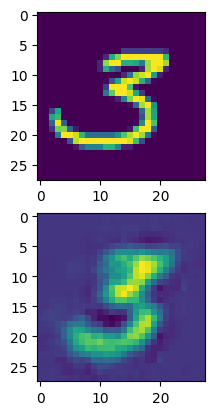

In [41]:
fig, ax = plt.subplots(2)
torch.no_grad()
x_train, y_train = next(iter(train_loader))
x_train = x_train.cuda()
output = model(x_train).cpu().detach().numpy()
ax[0].imshow(x_train.cpu()[0,0])
ax[1].imshow(output[0,0])